In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Post_process (has to be edited each time)

In [249]:
file_path = r"drive_cycles\drive_cycle_itr6.xlsx"

In [250]:
dc_pred = pd.read_excel(file_path)

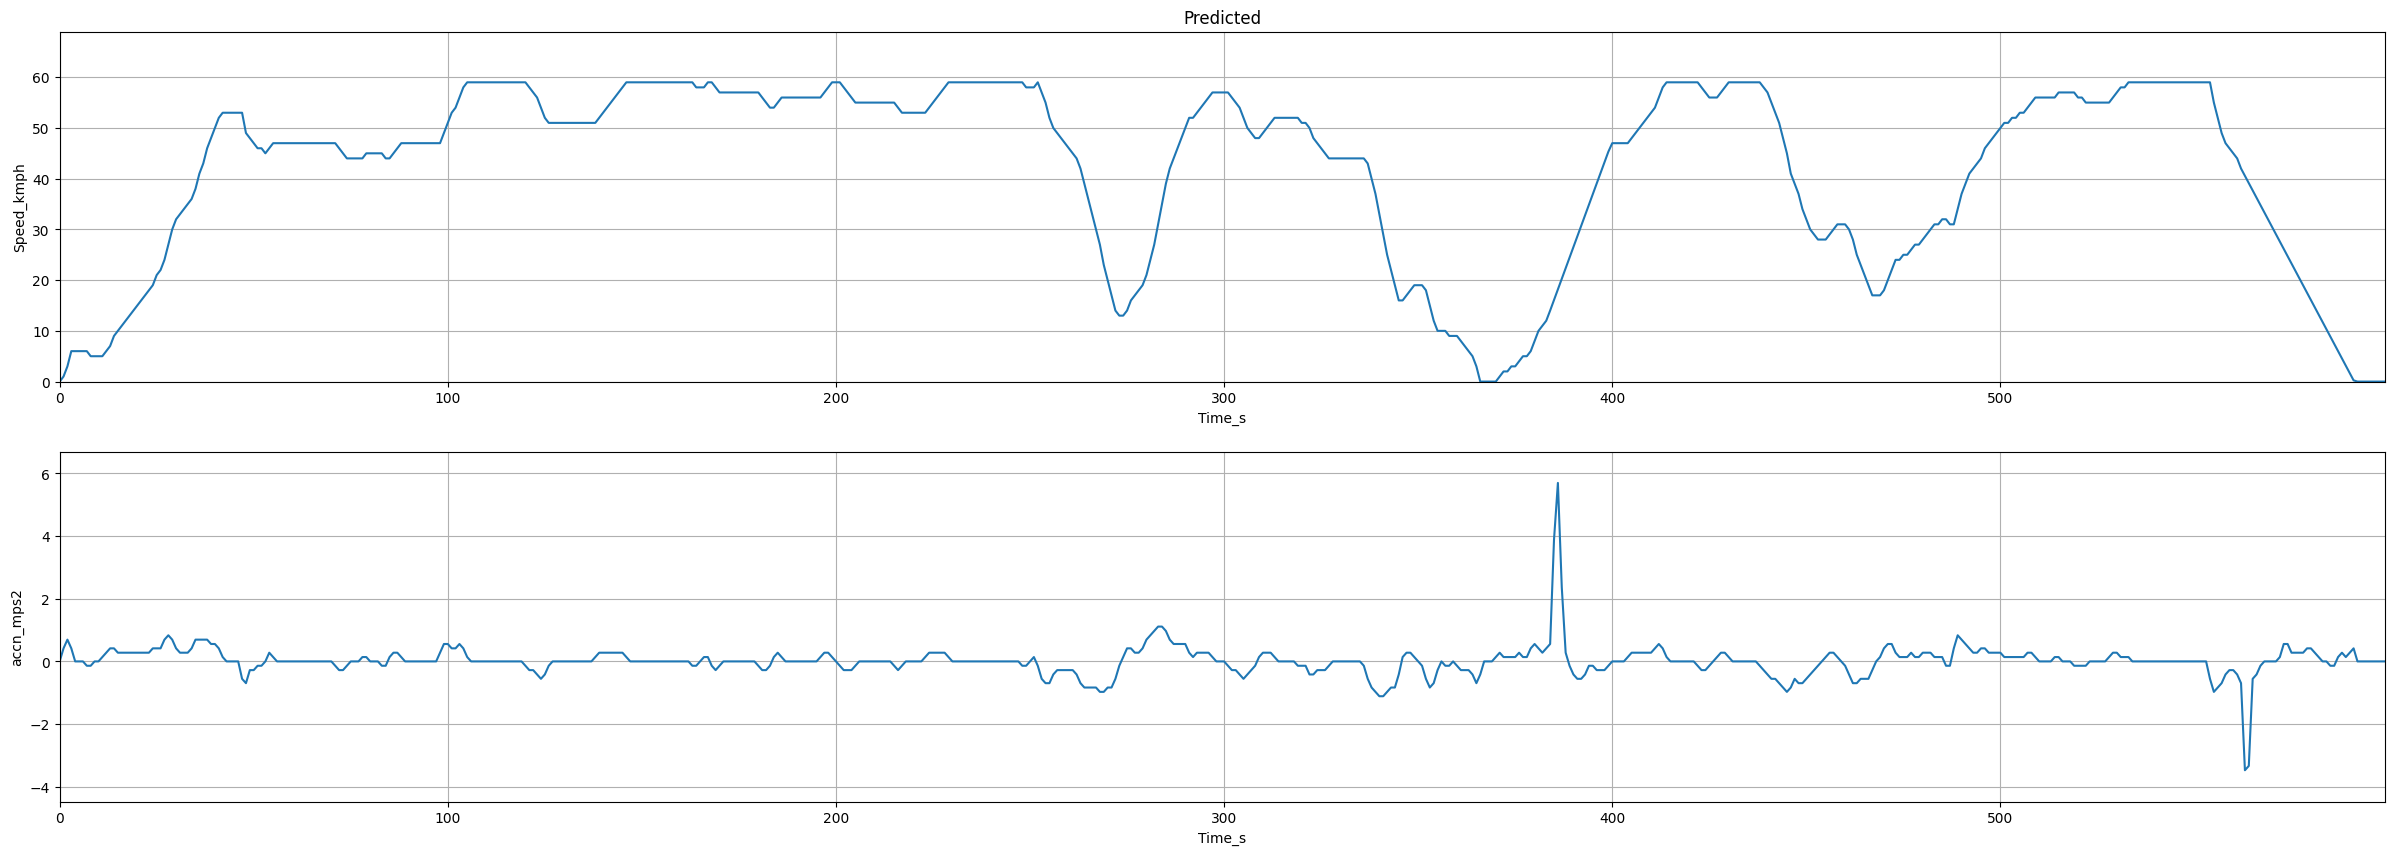

In [251]:
fig,ax = plt.subplots(2,1,figsize=[30,10])

#Speed plot
ax[0].plot(dc_pred['time_s'],dc_pred['speed_kmph'])
ax[0].set_xlim([0, dc_pred['time_s'].max()])
# ax[0].set_xlim([1000, 1200])
ax[0].set_ylim([0, dc_pred['speed_kmph'].max()+10])
ax[0].set_title('Predicted')
ax[0].set_xlabel('Time_s')
ax[0].set_ylabel('Speed_kmph')
ax[0].grid()

#Accn plot
ax[1].plot(dc_pred['time_s'],dc_pred['accn_mps2'])
ax[1].set_xlim([0, dc_pred['time_s'].max()])
# ax[1].set_xlim([1000, 1200])
ax[1].set_ylim([dc_pred['accn_mps2'].min()-1, dc_pred['accn_mps2'].max()+1])
ax[1].set_xlabel('Time_s')
ax[1].set_ylabel('accn_mps2')
ax[1].grid()

In [252]:
def preprocess_data(time, speed, acceleration):
    # Remove outliers (e.g. speeds above 80 mph or accelerations above 1 g)
    mask = (speed <= 80) & (np.abs(acceleration) >= 0) & (np.abs(acceleration) <= 1)
    time = time[mask]
    speed = speed[mask]
    acceleration = acceleration[mask]
    return time, speed, acceleration

In [253]:
dc_pred['time_s'],dc_pred['speed_kmph'],dc_pred['accn_mps2'] = preprocess_data(dc_pred['time_s'],dc_pred['speed_kmph'],dc_pred['accn_mps2'])

In [254]:
dc_pred = dc_pred.dropna()

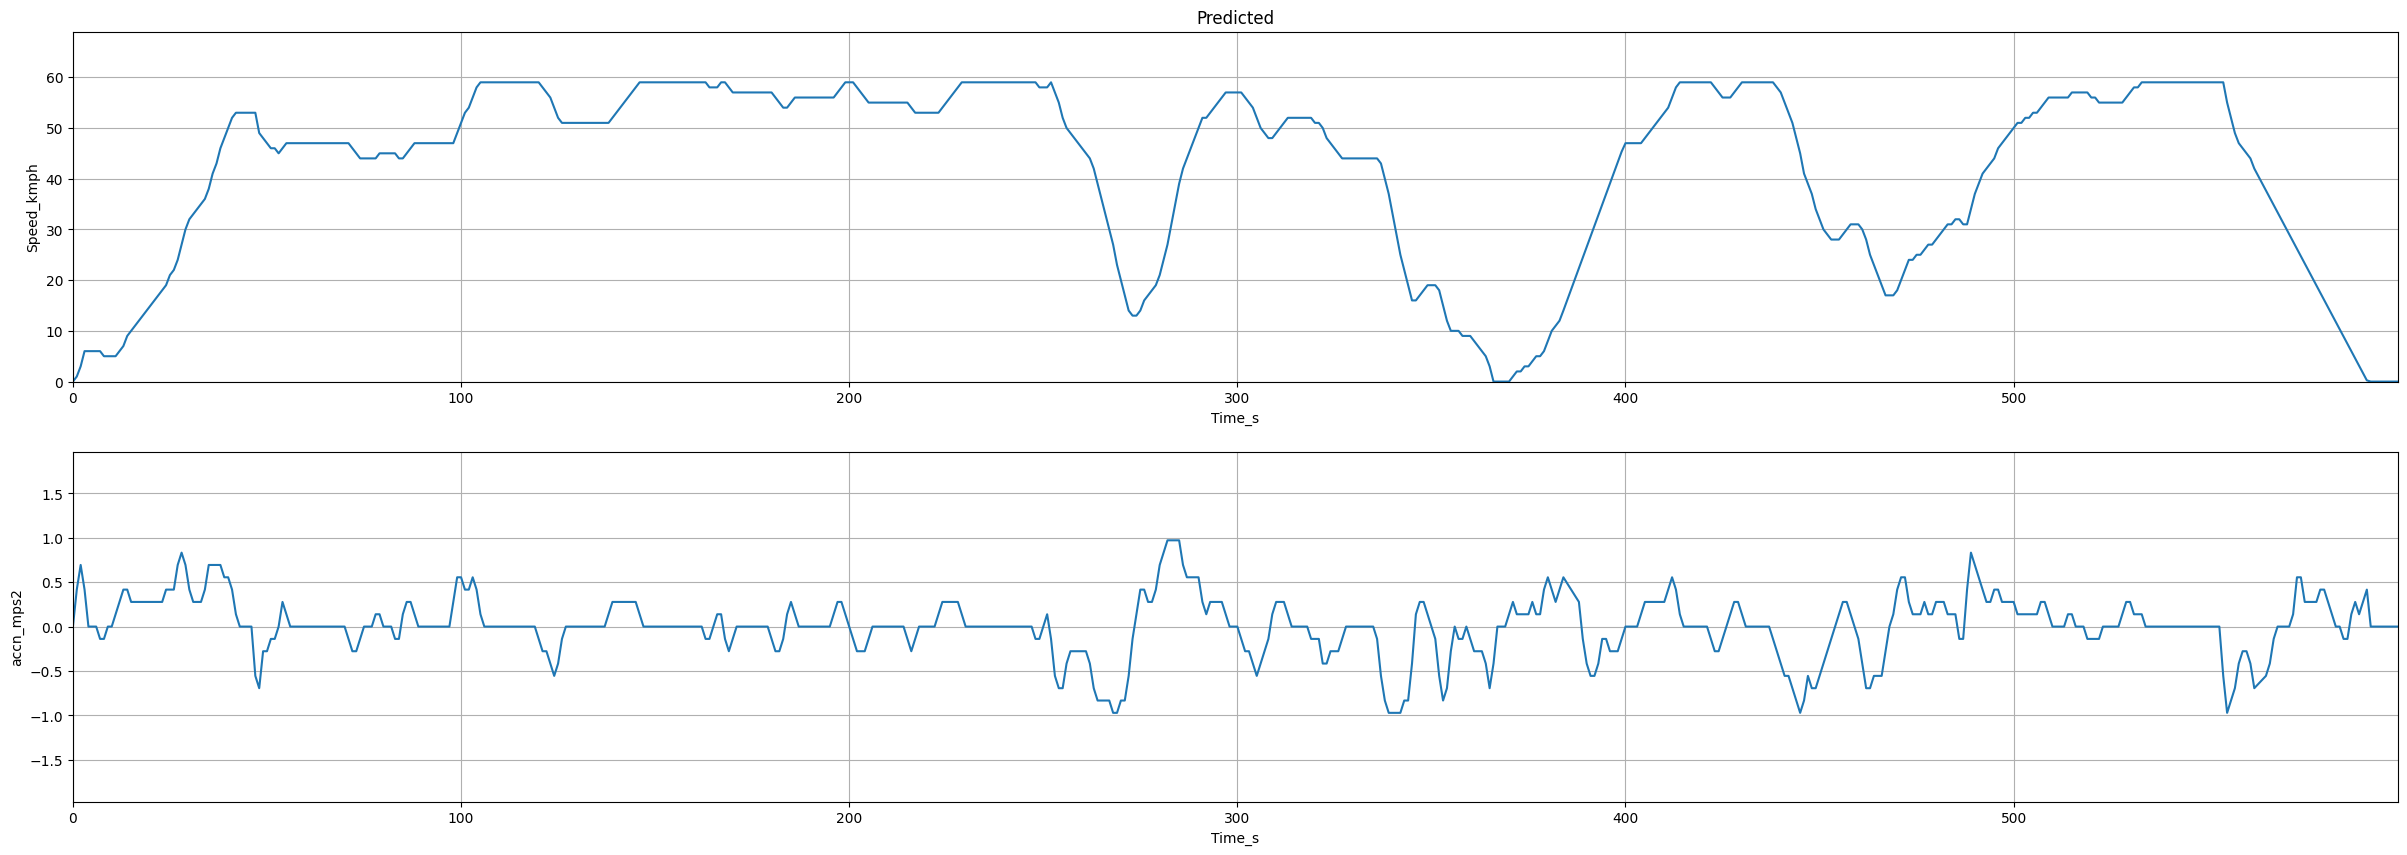

In [255]:
fig,ax = plt.subplots(2,1,figsize=[30,10])

#Speed plot
ax[0].plot(dc_pred['time_s'],dc_pred['speed_kmph'])
ax[0].set_xlim([0, dc_pred['time_s'].max()])
# ax[0].set_xlim([1000, 1200])
ax[0].set_ylim([0, dc_pred['speed_kmph'].max()+10])
ax[0].set_title('Predicted')
ax[0].set_xlabel('Time_s')
ax[0].set_ylabel('Speed_kmph')
ax[0].grid()

#Accn plot
ax[1].plot(dc_pred['time_s'],dc_pred['accn_mps2'])
ax[1].set_xlim([0, dc_pred['time_s'].max()])
# ax[1].set_xlim([1000, 1200])
ax[1].set_ylim([dc_pred['accn_mps2'].min()-1, dc_pred['accn_mps2'].max()+1])
ax[1].set_xlabel('Time_s')
ax[1].set_ylabel('accn_mps2')
ax[1].grid()

In [256]:
# find the cycle start
v0 = dc_pred['time_s'].loc[dc_pred['speed_kmph']==0]

In [257]:
dc_pred_post = dc_pred.iloc[:] #edit this

In [148]:
vf = dc_pred_post.loc[(dc_pred_post['speed_kmph']<10) & (dc_pred_post['time_s']>dc_pred_post['time_s'].max()-100)]
tf = vf[['time_s','speed_kmph']].loc[vf['speed_kmph'] == vf['speed_kmph'].min()].max()

In [149]:
tf.time_s.min()

1049

In [151]:
dc_pred_post = dc_pred_post.loc[dc_pred_post['time_s'] <= (tf.time_s.min())]

In [ ]:
desired_decel = 0.25 #m/s^2
v_end = vf['speed_kmph'].min()
t_end = round((v_end/3.6)/desired_decel)

In [258]:
# time_orig = np.arange(0,len(dc_pred_post['time_s']))
time_orig = dc_pred_post['time_s'].to_numpy()
# time_orig = np.append(time_orig,[max(time_orig)+t_end,max(time_orig)+t_end+15])
speed_orig = dc_pred_post['speed_kmph'].to_numpy()
# speed_orig = np.append(speed_orig,[0,0])
time_interp = np.arange(0, max(time_orig) + 1)
speed_interp = np.interp(time_interp,time_orig,speed_orig)

### dont edit below cells

In [259]:
diff_interp = [((speed_interp[i+1]-speed_interp[i-1])/3.6)/(time_interp[i+1]-time_interp[i-1]) for i in np.arange(1,len(time_interp)-1)]
accn_interp = np.insert(diff_interp,0,0)
accn_interp = np.append(accn_interp,0)

In [260]:
dc_pred_post = {'time_s': time_interp,
                'speed_kmph': speed_interp,
                'accn_mps2': accn_interp}
dc_pred_post = pd.DataFrame(dc_pred_post)
dc_pred_post['avg_speed_kmph'] = dc_pred_post['speed_kmph'].ewm(span=5).mean()

In [261]:
speed_interp = dc_pred_post['avg_speed_kmph'].to_numpy()
diff_interp = [((speed_interp[i+1]-speed_interp[i-1])/3.6)/(time_interp[i+1]-time_interp[i-1]) for i in np.arange(1,len(time_interp)-1)]
accn_interp = np.insert(diff_interp,0,0)
accn_interp = np.append(accn_interp,0)
dc_pred_post['avg_accn_mps2'] = accn_interp

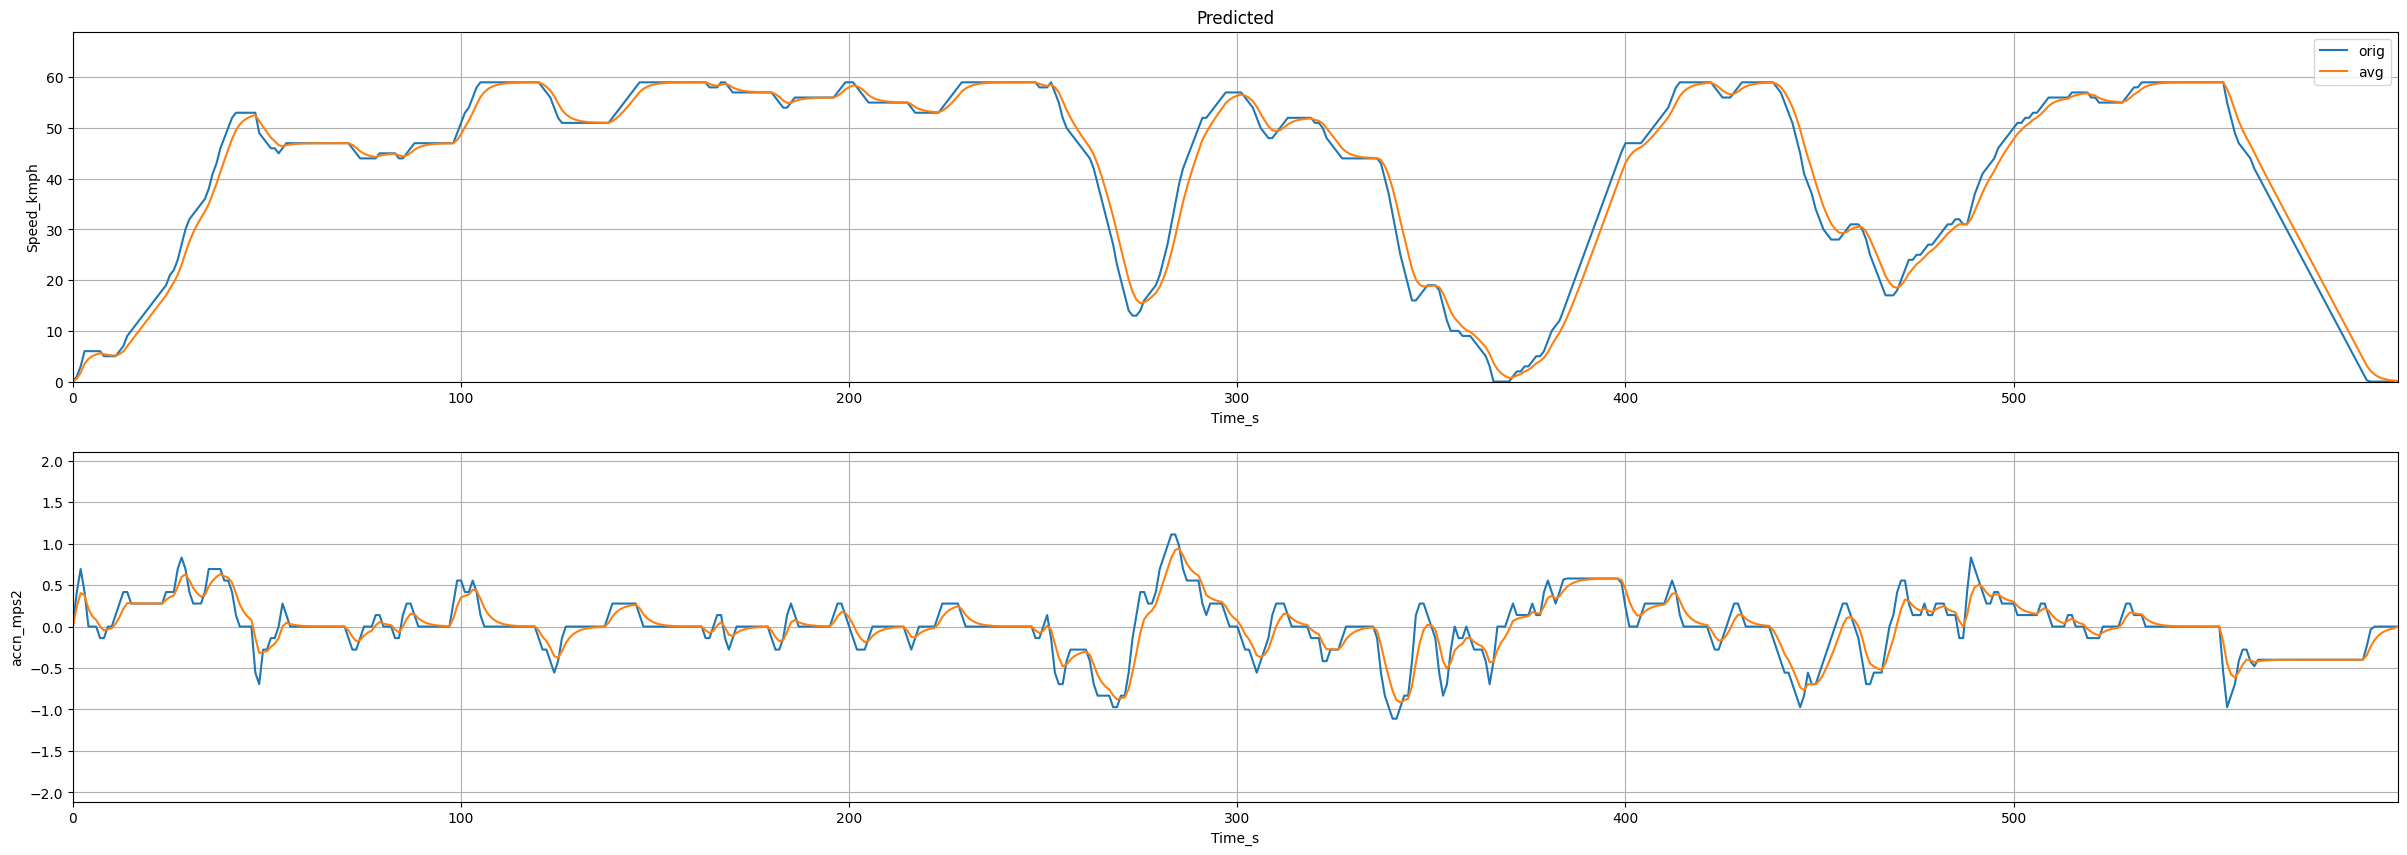

In [262]:
fig,ax = plt.subplots(2,1,figsize=[30,10])

#Speed plot
ax[0].plot(dc_pred_post['time_s'],dc_pred_post['speed_kmph'],label='orig')
ax[0].plot(dc_pred_post['time_s'],dc_pred_post['avg_speed_kmph'],label='avg')
ax[0].set_xlim([0, dc_pred_post['time_s'].max()])
# ax[0].set_xlim([1000, 1200])
ax[0].set_ylim([0, dc_pred_post['speed_kmph'].max()+10])
ax[0].set_title('Predicted')
ax[0].set_xlabel('Time_s')
ax[0].set_ylabel('Speed_kmph')
ax[0].legend()
ax[0].grid()

#Accn plot
ax[1].plot(dc_pred_post['time_s'],dc_pred_post['accn_mps2'],label = 'orig')
ax[1].plot(dc_pred_post['time_s'],dc_pred_post['avg_accn_mps2'],label = 'avg')
ax[1].set_xlim([0, dc_pred_post['time_s'].max()])
# ax[1].set_xlim([1000, 1200])
ax[1].set_ylim([dc_pred_post['accn_mps2'].min()-1, dc_pred_post['accn_mps2'].max()+1])
ax[1].set_xlabel('Time_s')
ax[1].set_ylabel('accn_mps2')
ax[0].legend()
ax[1].grid()

In [263]:
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:  
    dc_pred_post.to_excel(writer, sheet_name='itr2_avg',index = False)